# EDA

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import kstest
import sys
from feature_engine.encoding import OrdinalEncoder

sys.path.append('../src/')

from utils.modeling import feature_stability_plot

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

# Data

In [46]:
df_train = pd.read_parquet('../data/processed/fraud_dataset_v2_train.parquet.gzip')
df_valid = pd.read_parquet('../data/processed/fraud_dataset_v2_valid.parquet.gzip')

In [47]:
df_train.head(2)

a       b         c     d         e     f   g   h  \
0  4  0.7518  42638.24  50.0  0.190210   9.0  BR  20   
1  4  0.7576  34602.36   4.0  0.317697  33.0  BR   7   

                                                   i            j         k  \
0        Mochila Impermeable Mujer Importada Premiun  cat_0cd53cb  0.364921   
1  Placa De Rede ( Pci-e / Pci Express X1 / Mini ...  cat_41464e4  0.056129   

        l      m  n     o  p     q       r    s               fecha  monto  \
0  4338.0  366.0  1  NULO  Y  0.98  260445  100 2020-03-09 14:33:56  22.18   
1  4605.0  297.0  1  NULO  Y  0.06   34602  100 2020-03-16 15:07:38  10.95   

   score  fraude       ymd  day_of_week  hour_of_day period_of_day  
0  74.00       0  20200309            0           14     afternoon  
1  28.04       0  20200316            0           15     afternoon

In [48]:
hard_remove_features = ['fecha', 'ymd', 'i', 'j']
numerical_features = ['b', 'c', 'e', 'f', 'k', 'l', 'm', 'r', 'monto', 'score']
categorical_features = ['a', 'd', 'g', 'h', 'j', 'n', 'o', 'p', 'q', 's', 'period_of_day', 'day_of_week', 'hour_of_day']

In [49]:
ord_enc = OrdinalEncoder(
    encoding_method='arbitrary',
    variables=df_train[categorical_features].select_dtypes(include=['object']).columns.tolist()
).fit(df_train)

# Análise Univariada

## Estabilidade

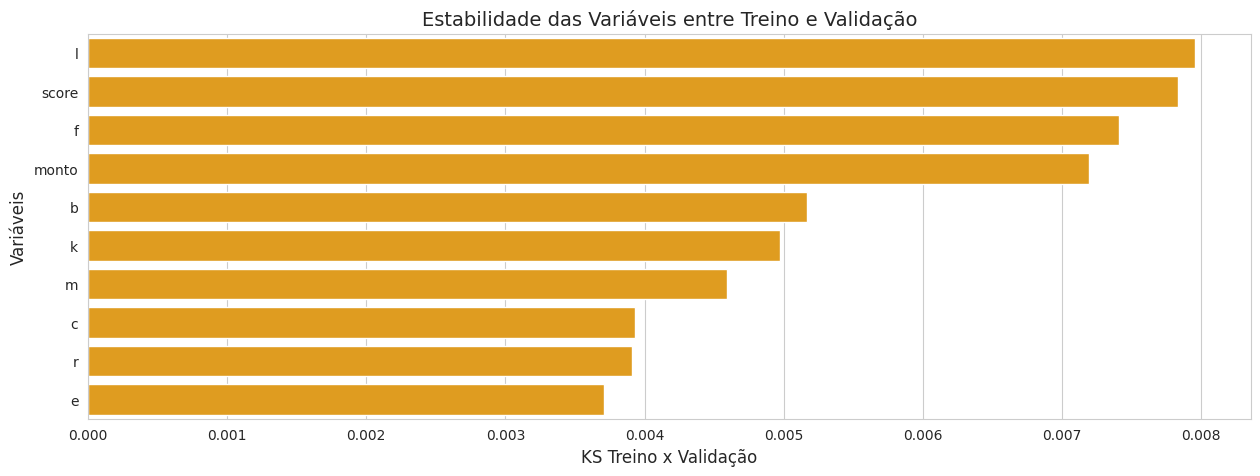

In [42]:
feature_stability_plot(df_train, df_valid, numerical_features, 'ks')

Todas as variáveis apresentam KS < 0.8, mostrando que não tem grande diferença entre a base de treino e a de validação. Com isso vamos seguir com todas as variáveis, caso alguma variável demonstrasse instabilidade por esse teste seria possível remove-la para evitar problemas de variação de performance do modelo.  

/home/diego/meli-fraud/.venv/lib/python3.12/site-packages/feature_engine/encoding/base_encoder.py:260: UserWarning: During the encoding, NaN values were introduced in the feature(s) g, j.
  warnings.warn(


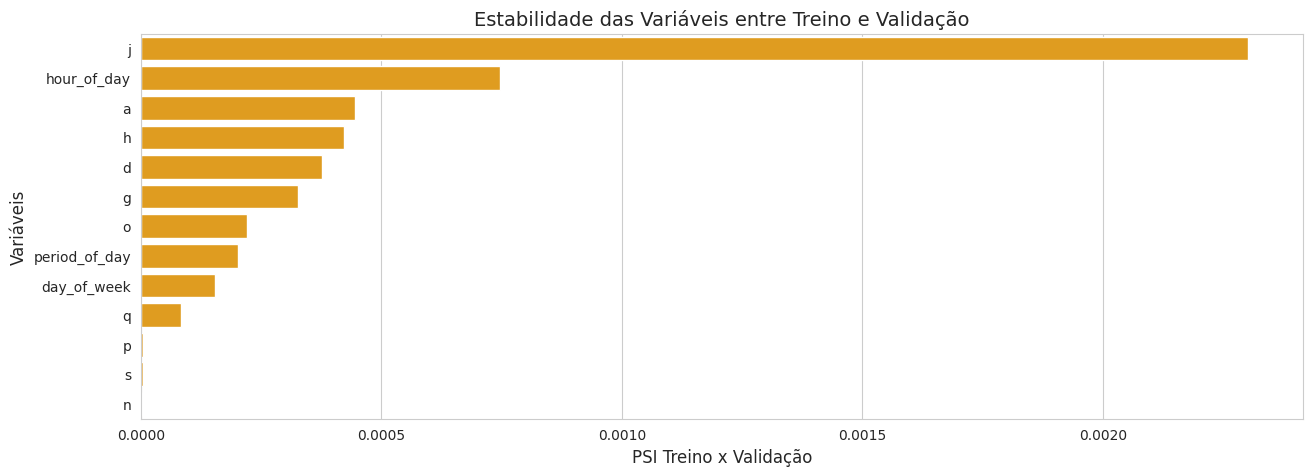

In [50]:
feature_stability_plot(ord_enc.transform(df_train), ord_enc.transform(df_valid), categorical_features, 'psi')

Avaliando o PSI das variáveis categóricas também não temos nenhuma variável alarmante com PSI >= 0.2, vamos manter todas as variáveis.

## Correlação com Target

In [51]:
df_corr_pearson_uni = df_train[numerical_features + ['fraude']].corr()['fraude'].drop('fraude')

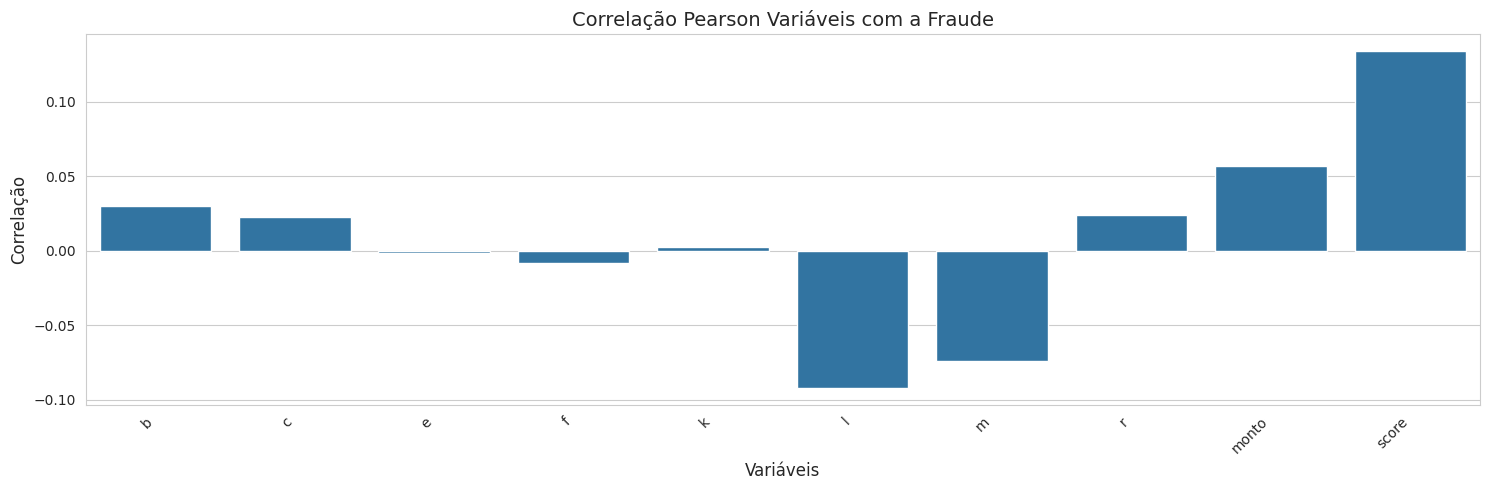

In [52]:
sns.set_style('whitegrid')

plt.figure(figsize=(15, 5))
sns.barplot(x=df_corr_pearson_uni.index, y=df_corr_pearson_uni.values)

plt.title(f'Correlação Pearson Variáveis com a Fraude', fontsize=14)
plt.xlabel('Variáveis', fontsize=12)
plt.ylabel('Correlação', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.tight_layout()

plt.show()

Avaliando relações lineares entre as variáveis explicativas e a variável resposta, não temos nenhuma variável super correlacionada, não demonstrando nenhum possível leak. Temos algumas variáveis com baixissima correlação com a variável resposta, porêm vamos mante-las visto que vamos utilizar técnicas de modelagem que avaliam relações não lineares e multivariadas.  

In [53]:
df_corr_spearman_uni = ord_enc.fit_transform(df_train[categorical_features + ['fraude']]).corr(method='spearman')['fraude'].drop('fraude')

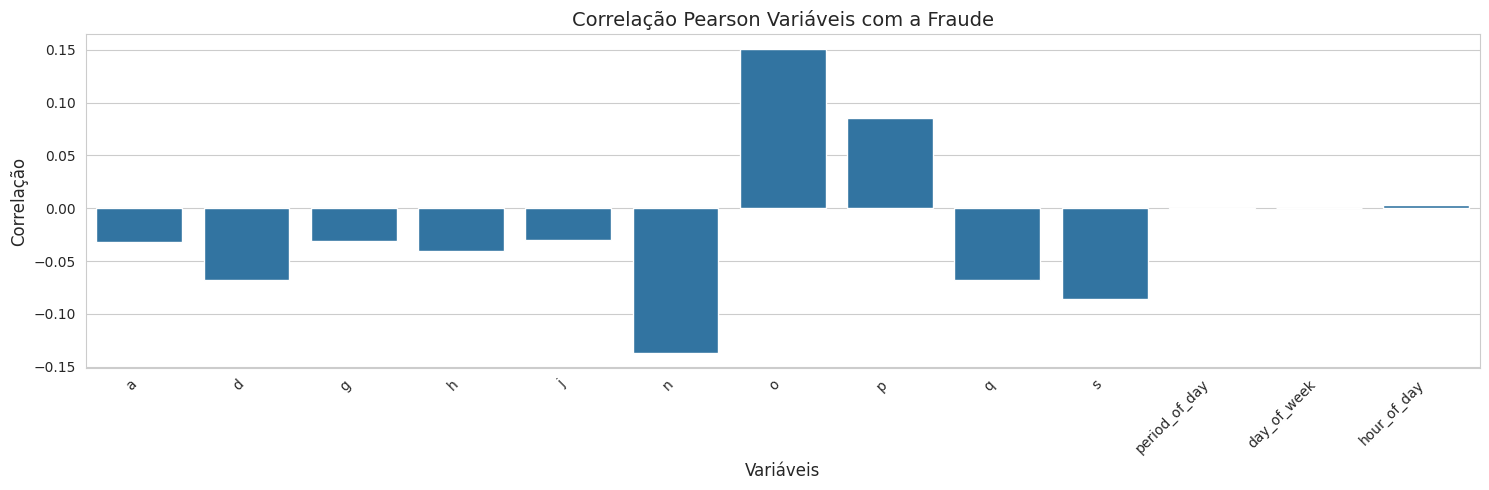

In [54]:
sns.set_style('whitegrid')

plt.figure(figsize=(15, 5))
sns.barplot(x=df_corr_spearman_uni.index, y=df_corr_spearman_uni.values)

plt.title(f'Correlação Pearson Variáveis com a Fraude', fontsize=14)
plt.xlabel('Variáveis', fontsize=12)
plt.ylabel('Correlação', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.tight_layout()

plt.show()

Avaliando a correlação das variáveis categóricas com a variável resposta, também não encontramos nenhum sinal de possível leak, vamos manter todas as variáveis para modelagem.  

# Análise Bivariada

### Correlação Numéricas

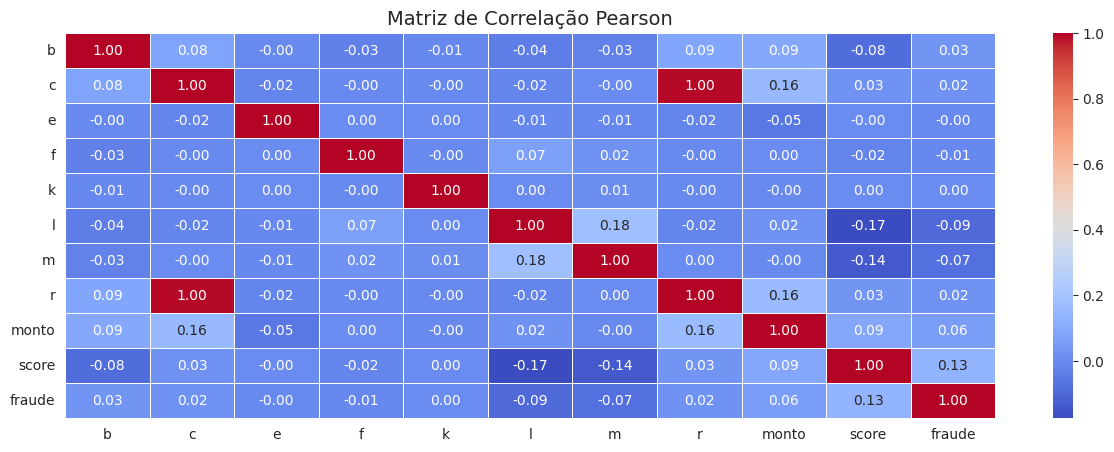

In [55]:
corr_matrix = df_train[numerical_features + ['fraude']].corr()

plt.figure(figsize=(15, 5))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', cbar=True, linewidths=0.5)

plt.title('Matriz de Correlação Pearson', fontsize=14)
plt.show()

### Analise 'r' - 'c'

Avaliando as variáveis numéricas, o que nos chama atenção são as variáveis r e c estão 100% correlacionadas, vamos olhar no detalhe para entender se são a mesma variável

In [56]:
df_train[['r', 'c']].describe().T

count           mean            std   min       25%       50%  \
r  129582.0  250998.780579  756819.698550  0.00  12663.25  61018.00   
c  129582.0  223154.396541  759960.208277  0.16  12663.70  42638.24   

          75%          max  
r  260445.000  13878743.00  
c  118024.535  13878743.71

A distribuição das variáveis é um pouco diferente, vamos olhar alguns casos para entender

In [57]:
df_train[['r', 'c']].head(20).T

0         1         2         3          4          5          6   \
r  260445.00  34602.00  11225.00  49224.00  147342.00  184488.00  340302.00   
c   42638.24  34602.36  11225.44  49224.53  147342.28  184488.52  340302.21   

         7          8        9        10         11       12        13  \
r  81218.00  260445.00  5912.00  5503.00  135175.00  1545.00  10369.00   
c  81218.25   42638.24  5912.21  5503.33  135175.58  1545.59  10369.91   

          14        15        16        17       18       19  
r  355766.00  26260.00  96638.00  27841.00  5048.00  4481.00  
c  355766.23  26260.58  96638.96  27841.18  5048.47  4481.47

Alguns valores estão arredondados e outros parecem estar totalmente trocados, vamos arredondar os valores e avaliar o que continua diferente

In [58]:
df_train['c_new'] = np.floor(df_train['c'])
df_train['r_dif_c'] = df_train[['r', 'c_new']].apply(lambda x: 1 if x['r'] != x['c_new'] else 0, axis=1)
df_train[df_train['r_dif_c'] == 1][['r', 'c', 'c_new']].head(2)

r         c    c_new
0  260445  42638.24  42638.0
8  260445  42638.24  42638.0

In [59]:
df_train[df_train['r_dif_c'] == 1][['r', 'c', 'c_new']].nunique()

r        1
c        1
c_new    1
dtype: int64

Tirando os arredondamentos, o que esta acontecendo é que tem 1 valor que esta sendo trocado por outro entre as duas variáveis (250445 por 43515.6), para decidir qual usar vamos avaliar a bad rate entre esses dois números, e escolher aquele que mais se adequa na distribuição, mesmo que a técnica leve em consideração a não linearidade isso pode nos ajudar na explicabilidade.

In [60]:
print(f"R - Bad rate categoria: {df_train[df_train['r'] == 260445]['fraude'].mean():.5f}, Bad rate > categoria: {df_train[df_train['r'] > 260445]['fraude'].mean():.5f}")
print(f"C - Bad rate categoria: {df_train[df_train['c'] == 42638.24]['fraude'].mean():.5f}, Bad rate > categoria: {df_train[df_train['c'] > 42638.24]['fraude'].mean():.5f}")

R - Bad rate categoria: 0.03519, Bad rate > categoria: 0.03853
C - Bad rate categoria: 0.03519, Bad rate > categoria: 0.03165


Com o valor acima e observando o gráfico de correlação de pearson, sabemos que a variável C e R tem correlação levemente positiva com a variável resposta, então vamos utilizar a variável R, visto que o valor esta melhor posicionado na distribuição.

### Correlação Categóricas

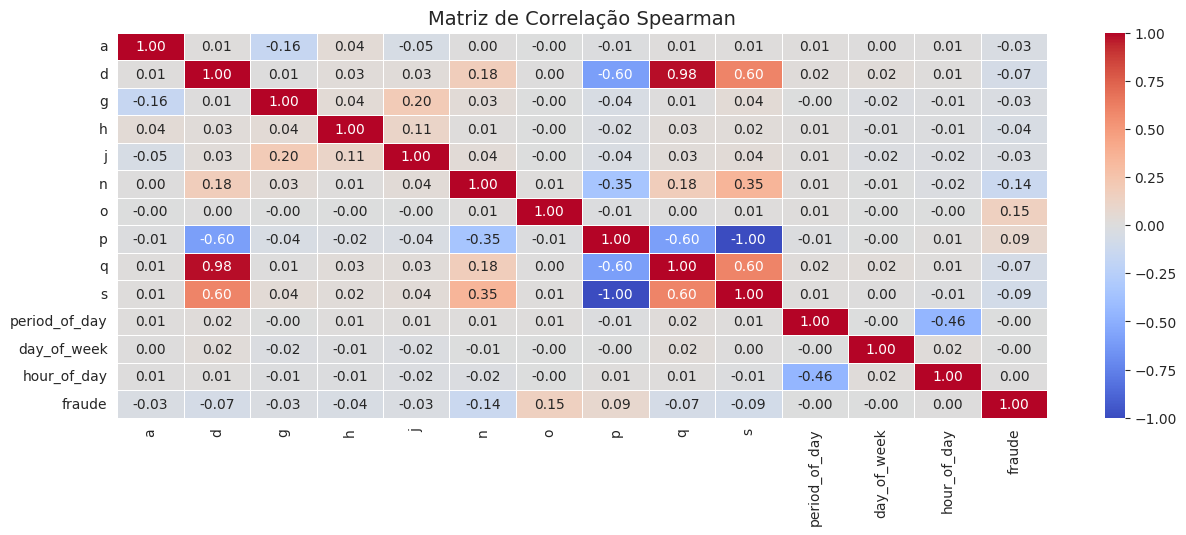

In [61]:
corr_matrix = ord_enc.fit_transform(df_train[categorical_features + ['fraude']]).corr(method='spearman')

plt.figure(figsize=(15, 5))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', cbar=True, linewidths=0.5)

plt.title('Matriz de Correlação Spearman', fontsize=14)
plt.show()

Nas variáveis categóricas temos dois pares de variáveis altamente correlacionadas, 'd' - 'q' e 'p' - 's', também temos 'p' - 'd' e 's' - 'd' e 'q' - 's' com uma valor relevante e vamos analisar.

### Analise 'd' - 'q'

In [21]:
df_train[['d', 'q']].describe().T

count       mean        std  min   25%    50%    75%   max
d  129582.0  21.558843  19.981176 -2.0  3.00  14.00  49.00  51.0
q  129582.0   0.418389   0.406008 -1.0  0.04   0.28   0.98   1.0

Observando a distribuição é possível notar que q é igual a d * ~50, dado isso vamos seguir removendo 'q' e manter 'd' com número inteiros.  

### Análise 'p' - 's'

In [22]:
ord_enc.fit_transform(df_train)[['p', 's']].describe().T

count       mean        std  min  25%    50%    75%    max
p  129582.0   0.437638   0.496098  0.0  0.0    0.0    1.0    1.0
s  129582.0  56.236206  49.609764  0.0  0.0  100.0  100.0  100.0

In [23]:
df_train[['p', 's']].head().T

0    1    2  3    4
p    Y    Y    Y  N    Y
s  100  100  100  0  100

As duas variáveis também são a mesma variável, uma em formato de string e outra numérica, vamos manter 's' por ser numérica.  

### Análise 's' - 'd'

In [24]:
df_train[['s', 'd']].describe().T

count       mean        std  min  25%    50%    75%    max
s  129582.0  56.236206  49.609764  0.0  0.0  100.0  100.0  100.0
d  129582.0  21.558843  19.981176 -2.0  3.0   14.0   49.0   51.0

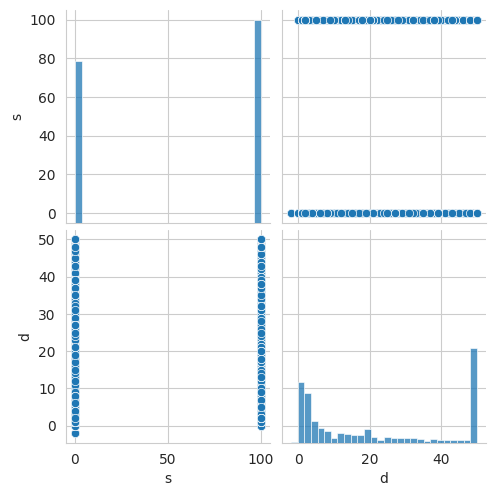

In [68]:
sns.pairplot(df_train[['s', 'd']])

São variáveis totalmente diferentes, 's' é binária e d tem maior cardinalidade, vamos seguir mantendo as duas

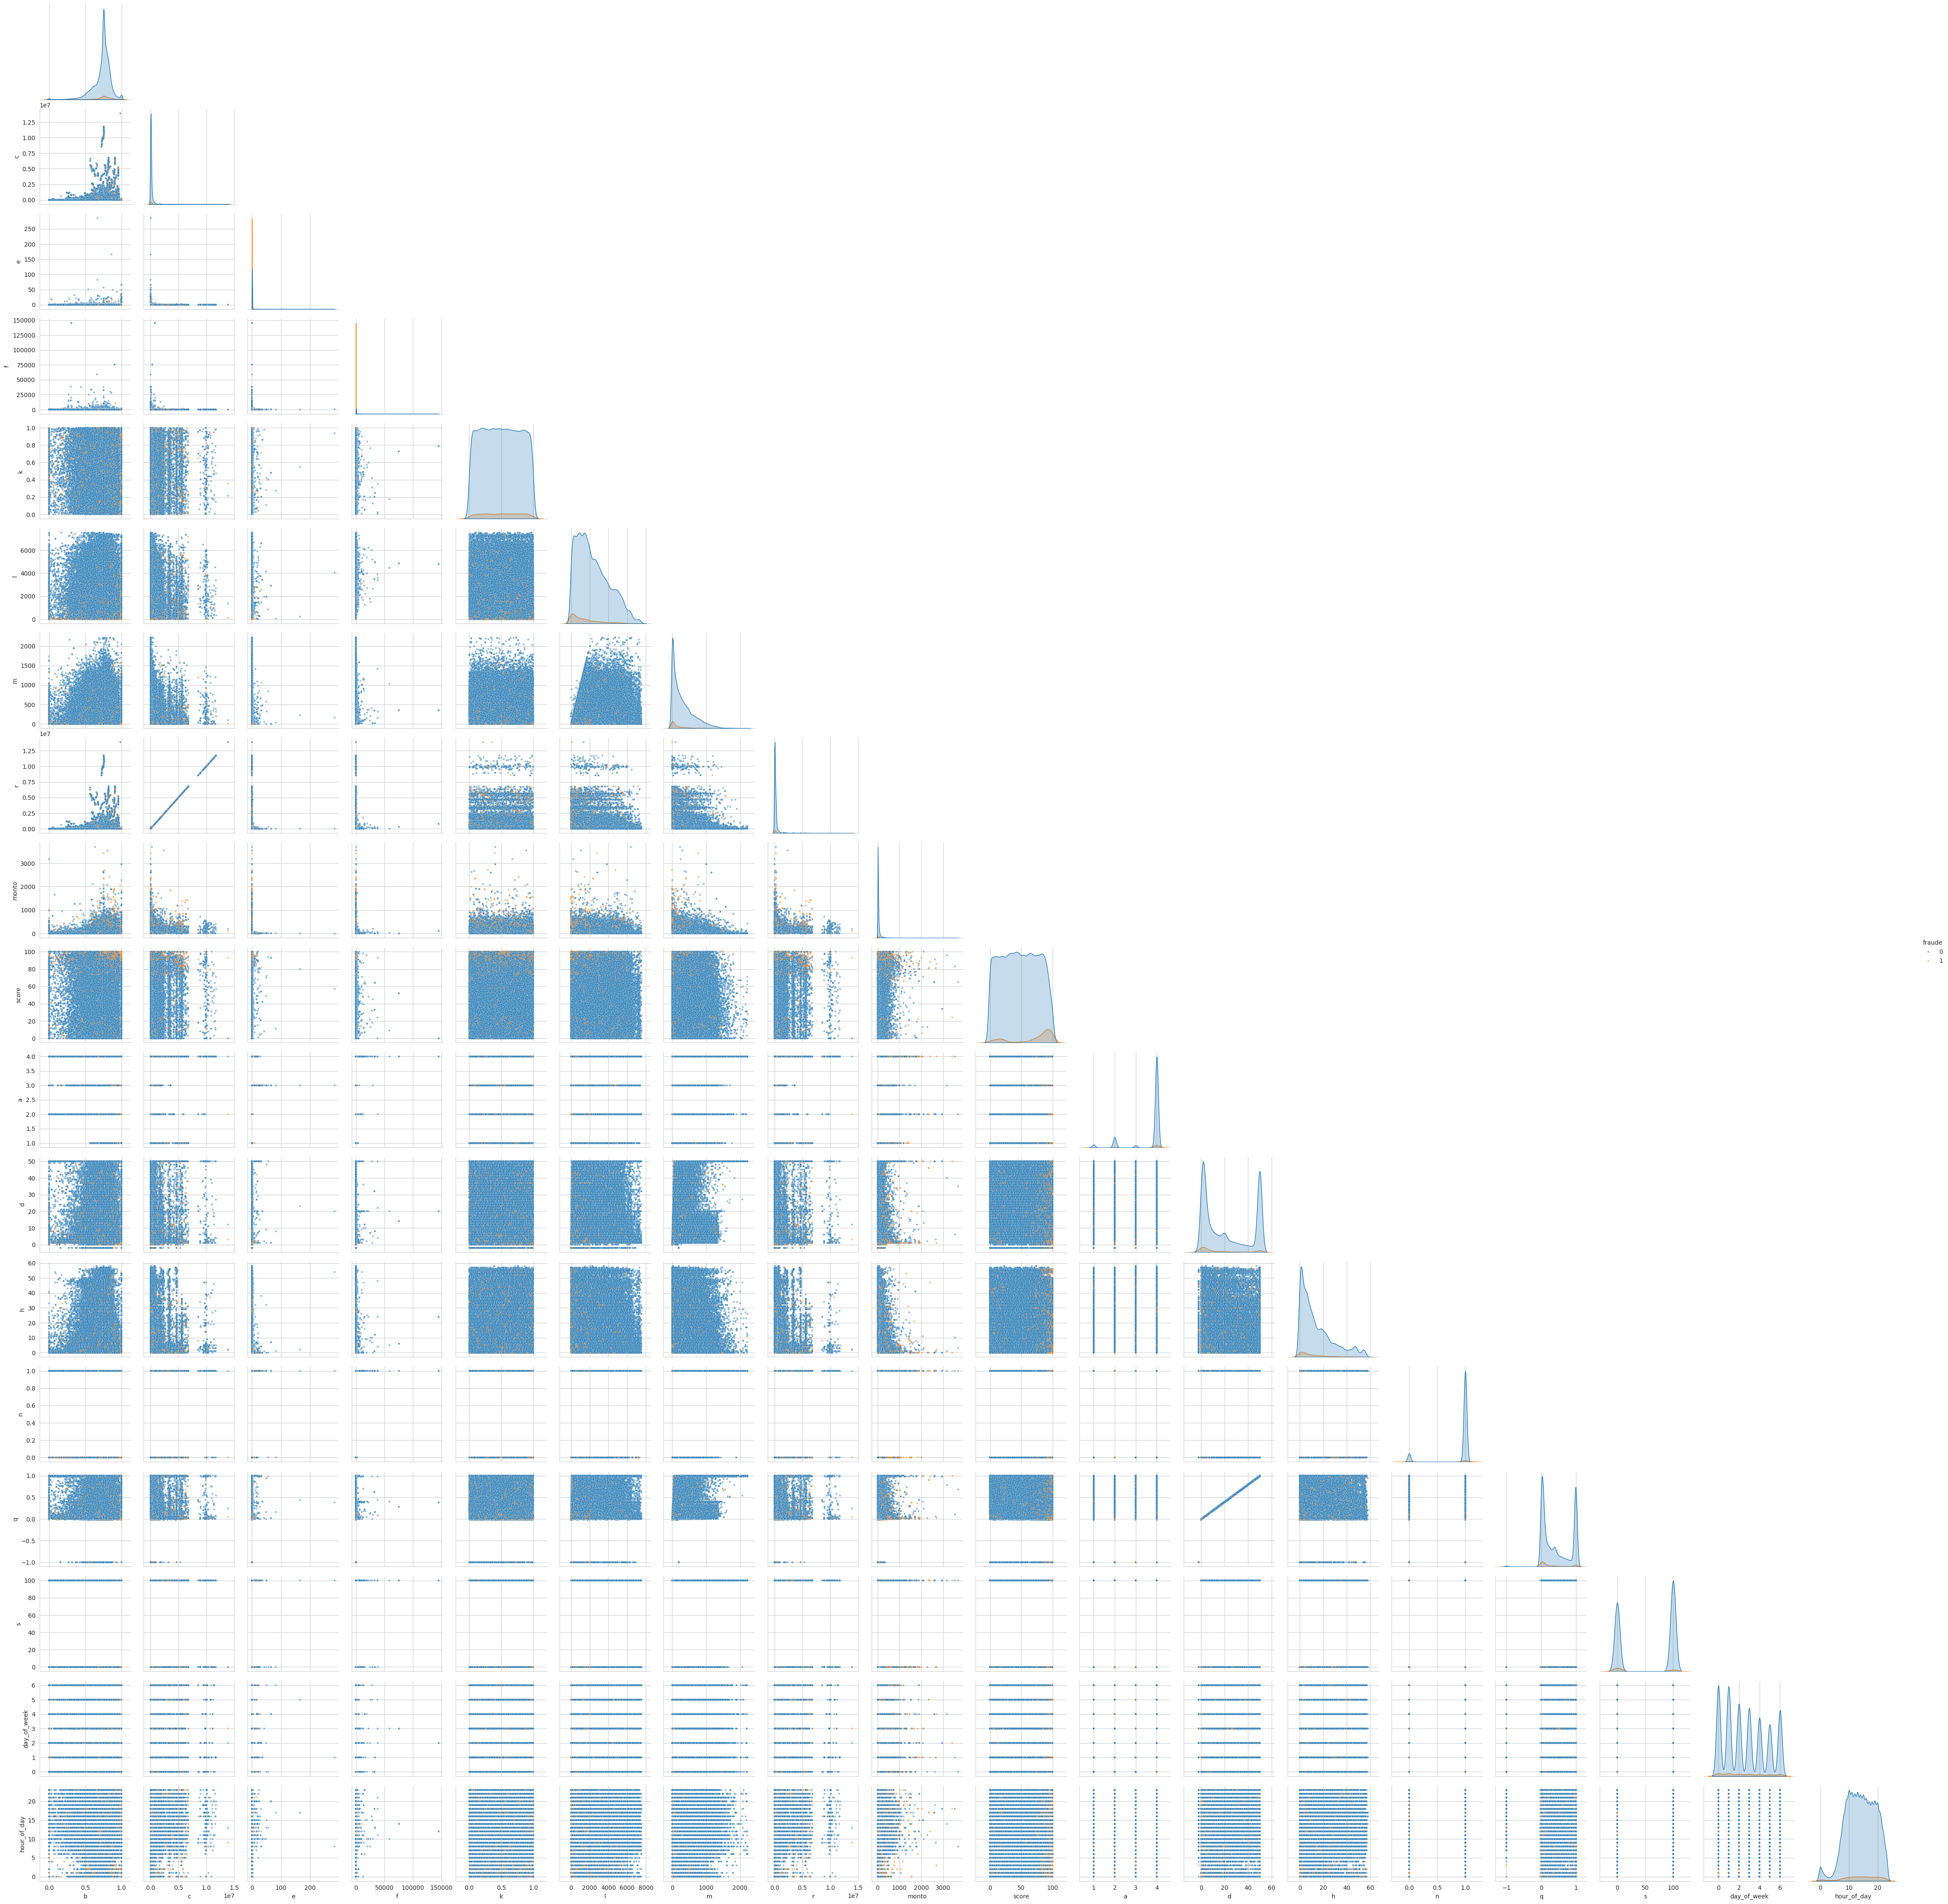

In [55]:
sns.pairplot(data=df_train[numerical_features + categorical_features + ['fraude']], 
             hue='fraude', corner=True, plot_kws={'s':10, 'alpha':0.5})

Analisando a relação entre duas variáveis não é possível notar nenhuma combinação a olho nú, capaz de separar com grande precisão os dados de fraude e não fraude.  
Resalto apenas o score, que consegue realaizar uma separação, acumulando mais fraudes no score próximo de 100, que já foi observado na parte de analise do baseline.  

# Conclusão EDA

Por fim, após analisaar algumas variáveis com relação a estabilidade e interação com outras e com a variável resposta, descartamos algumas ficando com as variáveis explicativas abaixo:  
- b
- e
- f
- k
- l
- m
- r
- monto
- a
- d
- g
- h
- j
- n
- o
- s
- period_of_day
- day_of_week
- hour_of_day

Não vamos utilizar a variável score pois a ideia é criar um novo score que possa complementa-lo ou substitui-lo.
Também tiveram algumas variáveis que foram deixadas de fora, como: i e j.

A variável i aparenta ser a descrição do produto comprado, podemos utiliza-la para tentar prever se a transação é fraudulenta fazendo o embedding dessa coluna e usando como variável para o modelo, em casos de marketplace isso indicaria conivência por parte do anunciante.  